## 1. Import Required Libraries

# Satellite Image Super-Resolution Pipeline

This notebook implements a deep learning pipeline for super-resolution of Sentinel-2 satellite imagery using the WorldStrat dataset. The goal is to achieve 4x or 8x upscaling while maintaining geospatial accuracy.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import tifffile

# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Device: Tesla P100-PCIE-16GB


## 2. Load and Explore Dataset Metadata

In [3]:
# Define paths
BASE_DIR = Path("/kaggle/input/worldstrat")
HR_DIR = BASE_DIR / "hr_dataset"
LR_DIR = BASE_DIR / "lr_dataset"
METADATA_PATH = BASE_DIR / "metadata.csv"
# SPLIT_PATH = BASE_DIR / "stratified_train_val_test_split.csv"
SPLIT_PATH = r'/kaggle/input/train-test-split/stratified_train_val_test_split.csv'

# Load metadata
metadata_df = pd.read_csv(METADATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)

print("Metadata Shape:", metadata_df.shape)
print("\nFirst few rows of metadata:")
print(metadata_df.head())
print("\n" + "="*80)
print("\nSplit Data Shape:", split_df.shape)
print("\nSplit Distribution:")
print(split_df['split'].value_counts())

Metadata Shape: (62848, 15)

First few rows of metadata:
           Unnamed: 0  n                                             bounds  \
0  Amnesty POI-10-1-1  1  [105.84161265950597, 13.147748954631947, 105.8...   
1  Amnesty POI-10-1-1  2  [105.84161265950597, 13.147748954631947, 105.8...   
2  Amnesty POI-10-1-1  3  [105.84161265950597, 13.147748954631947, 105.8...   
3  Amnesty POI-10-1-1  4  [105.84161265950597, 13.147748954631947, 105.8...   
4  Amnesty POI-10-1-1  5  [105.84161265950597, 13.147748954631947, 105.8...   

  lowres_date highres_date  area  cloud_cover  delta         lon        lat  \
0  2019-01-06   2019-01-27   2.5         0.06    -21  105.848905  13.154895   
1  2019-02-15   2019-01-27   2.5         0.15     19  105.848905  13.154895   
2  2019-01-31   2019-01-27   2.5         6.26      4  105.848905  13.154895   
3  2018-12-17   2019-01-27   2.5         0.73    -41  105.848905  13.154895   
4  2018-12-02   2019-01-27   2.5         0.11    -56  105.848905  13.1548

## 3. Data Analysis and Visualization

In [4]:
# Analyze class distribution
print("IPCC Class Distribution:")
print(split_df['IPCC Class'].value_counts())
print("\n" + "="*80)
print("\nSMOD Distribution:")
print(split_df['SMOD'].value_counts())
print("\n" + "="*80)
print("\nSource Distribution:")
print(split_df['source'].value_counts())

IPCC Class Distribution:
IPCC Class
Settlement     1699
Forest          742
Agriculture     691
Other           422
Grassland       204
Water            59
Wetland          40
Name: count, dtype: int64


SMOD Distribution:
SMOD
11    2213
30     582
12     320
21     263
23     197
13     165
22      99
10      89
Name: count, dtype: int64


Source Distribution:
source
Landcover     2421
UNHCR          959
ASMSpotter     353
Amnesty        195
Name: count, dtype: int64


## 4. Custom Dataset Class for LR-HR Image Pairs

In [5]:
# Check dataset structure
print("Checking dataset directories...")
print(f"\nLR Directory exists: {LR_DIR.exists()}")
print(f"HR Directory exists: {HR_DIR.exists()}")

if LR_DIR.exists():
    lr_subdirs = list(LR_DIR.glob("*"))[:10]
    print(f"\nFirst 10 subdirectories in LR: {[d.name for d in lr_subdirs if d.is_dir()]}")
    
    # Check structure of first subdirectory
    if lr_subdirs:
        first_dir = [d for d in lr_subdirs if d.is_dir()][0] if any(d.is_dir() for d in lr_subdirs) else None
        if first_dir:
            print(f"\nStructure of {first_dir.name}:")
            for subdir in first_dir.iterdir():
                if subdir.is_dir():
                    files = list(subdir.glob("*"))[:5]
                    print(f"  {subdir.name}/: {[f.name for f in files]}")
else:
    print(f"\nERROR: LR Directory not found at: {LR_DIR}")
    print("Please ensure you have downloaded the WorldStrat dataset and updated the path.")

if HR_DIR.exists():
    hr_subdirs = list(HR_DIR.glob("*"))[:10]
    print(f"\nFirst 10 subdirectories in HR: {[d.name for d in hr_subdirs if d.is_dir()]}")
    
    # Check structure of first subdirectory
    if hr_subdirs:
        first_dir = [d for d in hr_subdirs if d.is_dir()][0] if any(d.is_dir() for d in hr_subdirs) else None
        if first_dir:
            print(f"\nStructure of {first_dir.name}:")
            for subdir in first_dir.iterdir():
                if subdir.is_dir():
                    files = list(subdir.glob("*"))[:5]
                    print(f"  {subdir.name}/: {[f.name for f in files]}")
else:
    print(f"\nERROR: HR Directory not found at: {HR_DIR}")
    print("Please ensure you have downloaded the WorldStrat dataset and updated the path.")

print("\n" + "="*80)

Checking dataset directories...

LR Directory exists: True
HR Directory exists: True

First 10 subdirectories in LR: ['UNHCR-LBNs004412', 'Landcover-242828', 'UNHCR-TURs004678', 'Landcover-955196', 'Landcover-771823', 'UNHCR-SDNs015669', 'Amnesty POI-3-3-1', 'Landcover-509724', 'Landcover-776517', 'Landcover-777876']

Structure of UNHCR-LBNs004412:
  L2A/: ['UNHCR-LBNs004412-5-CLM.tiff', 'UNHCR-LBNs004412-8-CLP.tiff', 'UNHCR-LBNs004412-2-dataMask.tiff', 'UNHCR-LBNs004412-7-CLP.tiff', 'UNHCR-LBNs004412-3-SCL.tiff']

First 10 subdirectories in HR: ['12bit']

Structure of 12bit:
  UNHCR-LBNs004412/: ['UNHCR-LBNs004412_rgb.png', 'UNHCR-LBNs004412_ps.tiff', 'UNHCR-LBNs004412_rgbn.tiff', 'UNHCR-LBNs004412_pan.tiff']
  Landcover-242828/: ['Landcover-242828_rgbn.tiff', 'Landcover-242828_pan.tiff', 'Landcover-242828_rgb.png', 'Landcover-242828_ps.tiff']
  UNHCR-TURs004678/: ['UNHCR-TURs004678_rgbn.tiff', 'UNHCR-TURs004678_ps.tiff', 'UNHCR-TURs004678_rgb.png', 'UNHCR-TURs004678_pan.tiff']
  Land

In [6]:
class SatelliteSRDataset(Dataset):
    """
    Custom Dataset for Satellite Image Super-Resolution
    Pairs Low-Resolution (LR) and High-Resolution (HR) images
    """
    def __init__(self, split_df, lr_dir, hr_dir, split='train', transform=None, scale_factor=4):
        """
        Args:
            split_df: DataFrame with tile information and splits
            lr_dir: Path to low-resolution images directory
            hr_dir: Path to high-resolution images directory
            split: 'train', 'val', or 'test'
            transform: Optional transform to be applied
            scale_factor: Upscaling factor (4x or 8x)
        """
        self.split_df = split_df[split_df['split'] == split].reset_index(drop=True)
        self.lr_dir = Path(lr_dir)
        self.hr_dir = Path(hr_dir)
        self.transform = transform
        self.scale_factor = scale_factor
        
        # Check if directories exist
        if not self.lr_dir.exists():
            print(f"WARNING: LR directory does not exist: {self.lr_dir}")
            print(f"Please ensure the dataset is downloaded and the path is correct.")
        if not self.hr_dir.exists():
            print(f"WARNING: HR directory does not exist: {self.hr_dir}")
            print(f"Please ensure the dataset is downloaded and the path is correct.")
        
        # Filter only tiles that exist
        self.valid_indices = []
        checked_count = 0
        max_check = min(10, len(self.split_df))  # Check first 10 for debugging
        
        for idx in range(len(self.split_df)):
            tile_name = self.split_df.iloc[idx]['tile']
            lr_path, hr_path = self._get_image_paths(tile_name)
            
            # Debug: Show first few attempts
            if checked_count < 5:
                if lr_path is None:
                    print(f"Debug: No LR path found for tile '{tile_name}'")
                if hr_path is None:
                    print(f"Debug: No HR path found for tile '{tile_name}'")
                checked_count += 1
            
            if lr_path and hr_path:
                self.valid_indices.append(idx)
        
        print(f"{split.upper()} Dataset: {len(self.valid_indices)} valid image pairs found out of {len(self.split_df)} tiles")
        
        if len(self.valid_indices) == 0:
            print("\nERROR: No valid image pairs found!")
            print(f"LR Directory: {self.lr_dir}")
            print(f"HR Directory: {self.hr_dir}")
            if self.lr_dir.exists():
                lr_subdirs = list(self.lr_dir.glob("*"))[:5]
                print(f"Sample LR subdirectories: {[d.name for d in lr_subdirs if d.is_dir()]}")
            if self.hr_dir.exists():
                hr_subdirs = list(self.hr_dir.glob("*"))[:5]
                print(f"Sample HR subdirectories: {[d.name for d in hr_subdirs if d.is_dir()]}")
    
    def _get_image_paths(self, tile_name):
        """Find LR and HR image paths for a given tile"""
        # Search for LR images in L2A folder
        # Structure: lr_dataset/{tile_name}/L2A/*.tiff
        lr_folder = self.lr_dir / tile_name / "L2A"
        if not lr_folder.exists():
            return None, None
        
        # Look for any TIFF file in L2A folder (multiple patterns exist)
        lr_images = list(lr_folder.glob("*.tiff"))
        if not lr_images:
            return None, None
        
        # Use the first TIFF file found (typically the data file)
        lr_image = lr_images[0]
        
        # Search for HR images in 12bit folder
        # Structure: hr_dataset/12bit/{tile_name}/{tile_name}_rgb.png
        hr_image = self.hr_dir / "12bit" / tile_name / f"{tile_name}_rgb.png"
        if not hr_image.exists():
            return None, None
        
        return lr_image, hr_image
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        tile_name = self.split_df.iloc[actual_idx]['tile']
        
        lr_path, hr_path = self._get_image_paths(tile_name)
        
        try:
            # Load HR image with OpenCV
            hr_img = cv2.imread(str(hr_path))
            if hr_img is None:
                # If corrupted, try next sample
                print(f"Warning: Failed to load HR image for tile: {tile_name}, skipping...")
                return self.__getitem__((idx + 1) % len(self))
            
            # Convert BGR to RGB
            if len(hr_img.shape) == 3:
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
            
            # Load LR image with tifffile (handles multi-band TIFF)
            lr_img = tifffile.imread(str(lr_path))
            if lr_img is None:
                print(f"Warning: Failed to load LR image for tile: {tile_name}, skipping...")
                return self.__getitem__((idx + 1) % len(self))
        except Exception as e:
            # Handle any other loading errors (corrupted files, etc.)
            print(f"Warning: Error loading images for tile {tile_name}: {str(e)}, skipping...")
            return self.__getitem__((idx + 1) % len(self))
        
        # Handle multi-band Sentinel-2 imagery
        # Sentinel-2 has 12 bands, we need RGB (bands 4, 3, 2 = Red, Green, Blue)
        # Or if bands are in different order, take first 3 channels
        if len(lr_img.shape) == 3 and lr_img.shape[2] > 3:
            # Try to extract RGB bands (4, 3, 2 for Sentinel-2)
            if lr_img.shape[2] >= 4:
                # Bands are typically: 1=Coastal, 2=Blue, 3=Green, 4=Red
                # For RGB visualization: R=band4, G=band3, B=band2 (indices 3,2,1)
                lr_img = np.stack([lr_img[:, :, 3], lr_img[:, :, 2], lr_img[:, :, 1]], axis=2)
            else:
                lr_img = lr_img[:, :, :3]
        elif len(lr_img.shape) == 2:
            # Grayscale, convert to RGB
            lr_img = np.stack([lr_img, lr_img, lr_img], axis=2)
        
        # Handle 16-bit to 8-bit normalization for LR
        if lr_img.dtype == np.uint16:
            # Normalize 16-bit to 8-bit range
            lr_img = (lr_img / 256).astype(np.uint8)
        elif lr_img.dtype == np.uint32 or lr_img.dtype == np.float32 or lr_img.dtype == np.float64:
            # Normalize to 0-255 range
            lr_img = ((lr_img - lr_img.min()) / (lr_img.max() - lr_img.min() + 1e-8) * 255).astype(np.uint8)
        
        # Resize to ensure consistent dimensions
        target_size = 256
        lr_size = target_size // self.scale_factor
        
        lr_img = cv2.resize(lr_img, (lr_size, lr_size), interpolation=cv2.INTER_CUBIC)
        hr_img = cv2.resize(hr_img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
        
        # Normalize to [0, 1]
        lr_img = lr_img.astype(np.float32) / 255.0
        hr_img = hr_img.astype(np.float32) / 255.0
        
        # Convert to tensor [C, H, W]
        lr_tensor = torch.from_numpy(lr_img.transpose(2, 0, 1))
        hr_tensor = torch.from_numpy(hr_img.transpose(2, 0, 1))
        
        return lr_tensor, hr_tensor, tile_name

In [7]:
# class SatelliteSRDataset(Dataset):
#     """
#     Custom Dataset for Satellite Image Super-Resolution
#     Pairs Low-Resolution (LR) and High-Resolution (HR) images
#     """
#     def __init__(self, split_df, lr_dir, hr_dir, split='train', transform=None, scale_factor=4):
#         """
#         Args:
#             split_df: DataFrame with tile information and splits
#             lr_dir: Path to low-resolution images directory
#             hr_dir: Path to high-resolution images directory
#             split: 'train', 'val', or 'test'
#             transform: Optional transform to be applied
#             scale_factor: Upscaling factor (4x or 8x)
#         """
#         self.split_df = split_df[split_df['split'] == split].reset_index(drop=True)
#         self.lr_dir = Path(lr_dir)
#         self.hr_dir = Path(hr_dir)
#         self.transform = transform
#         self.scale_factor = scale_factor
        
#         # Check if directories exist
#         if not self.lr_dir.exists():
#             print(f"WARNING: LR directory does not exist: {self.lr_dir}")
#             print(f"Please ensure the dataset is downloaded and the path is correct.")
#         if not self.hr_dir.exists():
#             print(f"WARNING: HR directory does not exist: {self.hr_dir}")
#             print(f"Please ensure the dataset is downloaded and the path is correct.")
        
#         # Filter only tiles that exist
#         self.valid_indices = []
#         checked_count = 0
#         max_check = min(10, len(self.split_df))  # Check first 10 for debugging
        
#         for idx in range(len(self.split_df)):
#             tile_name = self.split_df.iloc[idx]['tile']
#             lr_path, hr_path = self._get_image_paths(tile_name)
            
#             # Debug: Show first few attempts
#             if checked_count < 5:
#                 if lr_path is None:
#                     print(f"Debug: No LR path found for tile '{tile_name}'")
#                 if hr_path is None:
#                     print(f"Debug: No HR path found for tile '{tile_name}'")
#                 checked_count += 1
            
#             if lr_path and hr_path:
#                 self.valid_indices.append(idx)
        
#         print(f"{split.upper()} Dataset: {len(self.valid_indices)} valid image pairs found out of {len(self.split_df)} tiles")
        
#         if len(self.valid_indices) == 0:
#             print("\nERROR: No valid image pairs found!")
#             print(f"LR Directory: {self.lr_dir}")
#             print(f"HR Directory: {self.hr_dir}")
#             if self.lr_dir.exists():
#                 lr_subdirs = list(self.lr_dir.glob("*"))[:5]
#                 print(f"Sample LR subdirectories: {[d.name for d in lr_subdirs if d.is_dir()]}")
#             if self.hr_dir.exists():
#                 hr_subdirs = list(self.hr_dir.glob("*"))[:5]
#                 print(f"Sample HR subdirectories: {[d.name for d in hr_subdirs if d.is_dir()]}")
    
#     def _get_image_paths(self, tile_name):
#         """Find LR and HR image paths for a given tile"""
#         # Search for LR images in L2A folder
#         # Structure: lr_dataset/{tile_name}/L2A/*.tiff
#         lr_folder = self.lr_dir / tile_name / "L2A"
#         if not lr_folder.exists():
#             return None, None
        
#         # Look for any TIFF file in L2A folder (multiple patterns exist)
#         lr_images = list(lr_folder.glob("*.tiff"))
#         if not lr_images:
#             return None, None
        
#         # Use the first TIFF file found (typically the data file)
#         lr_image = lr_images[0]
        
#         # Search for HR images in 12bit folder
#         # Structure: hr_dataset/12bit/{tile_name}/{tile_name}_rgb.png
#         hr_image = self.hr_dir / "12bit" / tile_name / f"{tile_name}_rgb.png"
#         if not hr_image.exists():
#             return None, None
        
#         return lr_image, hr_image
    
#     def __len__(self):
#         return len(self.valid_indices)
    
#     def __getitem__(self, idx):
#         actual_idx = self.valid_indices[idx]
#         tile_name = self.split_df.iloc[actual_idx]['tile']
        
#         lr_path, hr_path = self._get_image_paths(tile_name)
        
#         # Load HR image with OpenCV
#         hr_img = cv2.imread(str(hr_path))
#         if hr_img is None:
#             raise ValueError(f"Failed to load HR image for tile: {tile_name}")
        
#         # Convert BGR to RGB
#         if len(hr_img.shape) == 3:
#             hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        
#         # Load LR image with tifffile (handles multi-band TIFF)
#         lr_img = tifffile.imread(str(lr_path))
#         if lr_img is None:
#             raise ValueError(f"Failed to load LR image for tile: {tile_name}")
        
#         # Handle multi-band Sentinel-2 imagery
#         # Sentinel-2 has 12 bands, we need RGB (bands 4, 3, 2 = Red, Green, Blue)
#         # Or if bands are in different order, take first 3 channels
#         if len(lr_img.shape) == 3 and lr_img.shape[2] > 3:
#             # Try to extract RGB bands (4, 3, 2 for Sentinel-2)
#             if lr_img.shape[2] >= 4:
#                 # Bands are typically: 1=Coastal, 2=Blue, 3=Green, 4=Red
#                 # For RGB visualization: R=band4, G=band3, B=band2 (indices 3,2,1)
#                 lr_img = np.stack([lr_img[:, :, 3], lr_img[:, :, 2], lr_img[:, :, 1]], axis=2)
#             else:
#                 lr_img = lr_img[:, :, :3]
#         elif len(lr_img.shape) == 2:
#             # Grayscale, convert to RGB
#             lr_img = np.stack([lr_img, lr_img, lr_img], axis=2)
        
#         # Handle 16-bit to 8-bit normalization for LR
#         if lr_img.dtype == np.uint16:
#             # Normalize 16-bit to 8-bit range
#             lr_img = (lr_img / 256).astype(np.uint8)
#         elif lr_img.dtype == np.uint32 or lr_img.dtype == np.float32 or lr_img.dtype == np.float64:
#             # Normalize to 0-255 range
#             lr_img = ((lr_img - lr_img.min()) / (lr_img.max() - lr_img.min() + 1e-8) * 255).astype(np.uint8)
        
#         # Resize to ensure consistent dimensions
#         target_size = 256
#         lr_size = target_size // self.scale_factor
        
#         lr_img = cv2.resize(lr_img, (lr_size, lr_size), interpolation=cv2.INTER_CUBIC)
#         hr_img = cv2.resize(hr_img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
        
#         # Normalize to [0, 1]
#         lr_img = lr_img.astype(np.float32) / 255.0
#         hr_img = hr_img.astype(np.float32) / 255.0
        
#         # Convert to tensor [C, H, W]
#         lr_tensor = torch.from_numpy(lr_img.transpose(2, 0, 1))
#         hr_tensor = torch.from_numpy(hr_img.transpose(2, 0, 1))
        
#         return lr_tensor, hr_tensor, tile_name

## 5. Create Data Loaders

In [8]:
# Configuration
SCALE_FACTOR = 4
BATCH_SIZE = 4
NUM_WORKERS = 0  # Set to 0 for Windows compatibility

# Create datasets
train_dataset = SatelliteSRDataset(split_df, LR_DIR, HR_DIR, split='train', scale_factor=SCALE_FACTOR)
val_dataset = SatelliteSRDataset(split_df, LR_DIR, HR_DIR, split='val', scale_factor=SCALE_FACTOR)
test_dataset = SatelliteSRDataset(split_df, LR_DIR, HR_DIR, split='test', scale_factor=SCALE_FACTOR)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\nDataset Summary:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

TRAIN Dataset: 3141 valid image pairs found out of 3141 tiles
VAL Dataset: 393 valid image pairs found out of 393 tiles
TEST Dataset: 394 valid image pairs found out of 394 tiles

Dataset Summary:
Train: 3141 samples
Val: 393 samples
Test: 394 samples


## 6. Visualize Sample Image Pairs

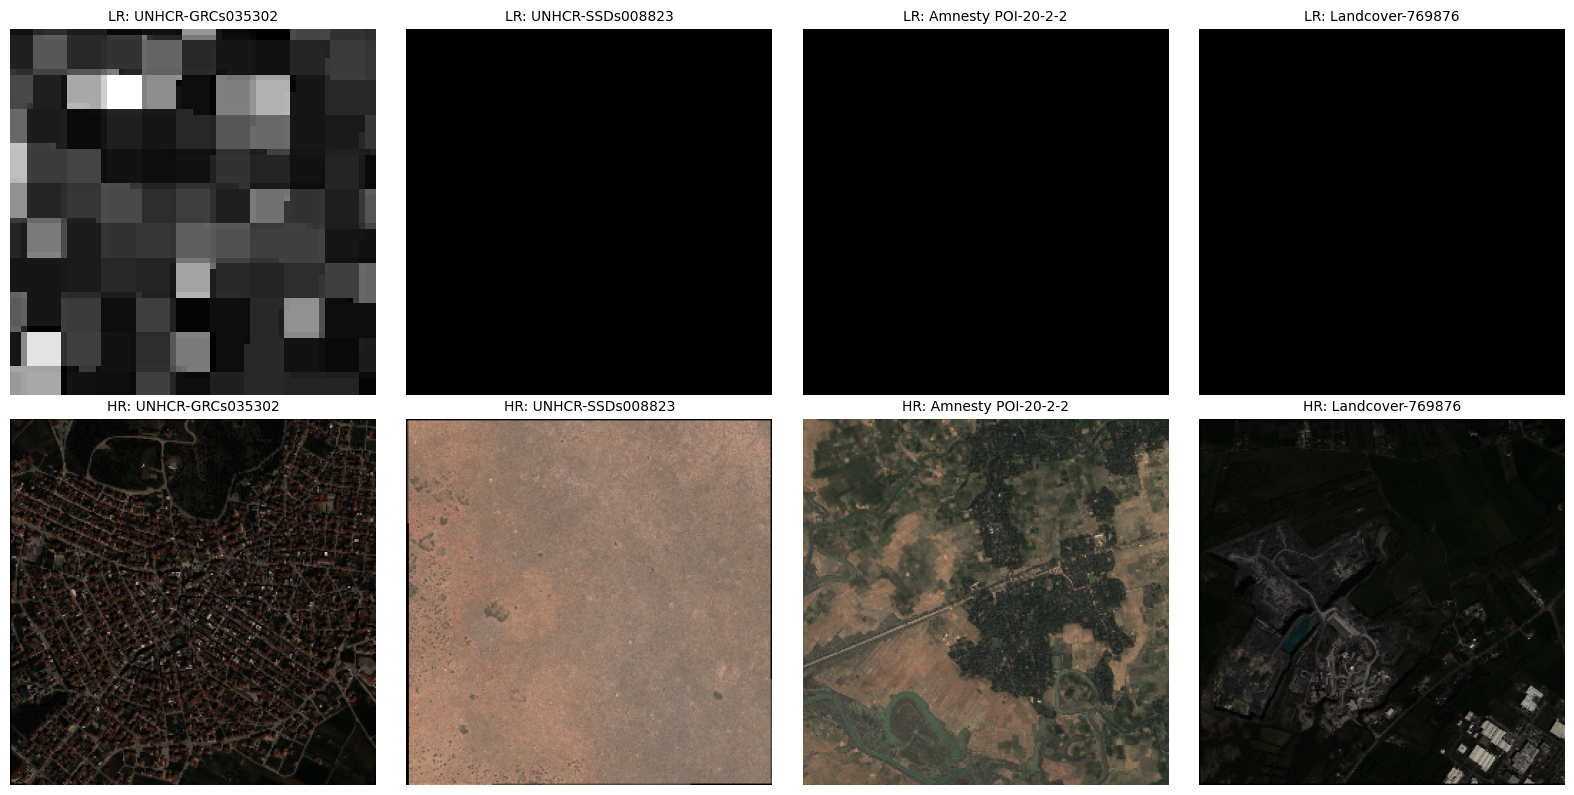

In [9]:
# Visualize samples
if len(train_dataset) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(4):
        lr, hr, tile_name = train_dataset[i]
        
        # Convert tensors to numpy arrays
        lr_np = lr.permute(1, 2, 0).numpy()
        hr_np = hr.permute(1, 2, 0).numpy()
        
        # Plot LR
        axes[0, i].imshow(lr_np)
        axes[0, i].set_title(f'LR: {tile_name[:20]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Plot HR
        axes[1, i].imshow(hr_np)
        axes[1, i].set_title(f'HR: {tile_name[:20]}', fontsize=10)
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Low Resolution', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('High Resolution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No training samples available for visualization")

## 7. Super-Resolution Model Architecture (SRCNN)

In [10]:
class ResidualBlock(nn.Module):
    """Residual Block for feature extraction"""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)


class SRResNet(nn.Module):
    """
    Super-Resolution Residual Network
    Modified architecture for satellite imagery
    """
    def __init__(self, scale_factor=4, num_channels=3, num_features=64, num_blocks=8):
        super(SRResNet, self).__init__()
        self.scale_factor = scale_factor
        
        # Initial feature extraction
        self.conv_input = nn.Conv2d(num_channels, num_features, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features) for _ in range(num_blocks)]
        )
        
        # Post-residual convolution
        self.conv_mid = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(num_features)
        
        # Upsampling layers
        self.upsampling = nn.Sequential(
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )
        
        # Output layer
        self.conv_output = nn.Conv2d(num_features, num_channels, kernel_size=9, padding=4)
    
    def forward(self, x):
        # Bicubic upsampling of input
        x_upsampled = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='bicubic', align_corners=False)
        
        # Feature extraction
        out = self.relu(self.conv_input(x))
        residual = out
        
        # Residual blocks
        out = self.residual_blocks(out)
        out = self.bn_mid(self.conv_mid(out))
        out += residual
        
        # Upsampling
        out = self.upsampling(out)
        
        # Output
        out = self.conv_output(out)
        
        # Add skip connection from upsampled input
        out = torch.clamp(out + x_upsampled, 0, 1)
        
        return out


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRResNet(scale_factor=SCALE_FACTOR, num_channels=3, num_features=64, num_blocks=8)
model = model.to(device)

print(f"Model initialized on device: {device}")
print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model initialized on device: cuda

Model Parameters: 956,547


## 8. Loss Functions and Optimizer

In [11]:
class PerceptualLoss(nn.Module):
    """
    Perceptual loss combining MSE and edge preservation
    Prevents hallucination by focusing on structural accuracy
    """
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
    
    def forward(self, sr, hr):
        # Pixel-wise MSE loss
        mse = self.mse_loss(sr, hr)
        
        # Edge preservation loss (Laplacian)
        laplacian_kernel = torch.tensor([[[[-1, -1, -1],
                                           [-1,  8, -1],
                                           [-1, -1, -1]]]], dtype=torch.float32).to(sr.device)
        
        # Apply Laplacian to each channel
        edge_loss = 0
        for c in range(sr.shape[1]):
            sr_edges = nn.functional.conv2d(sr[:, c:c+1], laplacian_kernel, padding=1)
            hr_edges = nn.functional.conv2d(hr[:, c:c+1], laplacian_kernel, padding=1)
            edge_loss += self.mse_loss(sr_edges, hr_edges)
        
        edge_loss = edge_loss / sr.shape[1]
        
        # Combined loss with edge emphasis
        total_loss = mse + 0.1 * edge_loss
        
        return total_loss


# Loss and optimizer
criterion = PerceptualLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Loss function and optimizer initialized")

Loss function and optimizer initialized


## 9. Evaluation Metrics (PSNR and SSIM)

In [12]:
def calculate_psnr(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio"""
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    
    psnr_values = []
    for i in range(img1_np.shape[0]):
        p = psnr(img2_np[i].transpose(1, 2, 0), img1_np[i].transpose(1, 2, 0), data_range=1.0)
        psnr_values.append(p)
    
    return np.mean(psnr_values)


def calculate_ssim(img1, img2):
    """Calculate Structural Similarity Index"""
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    
    ssim_values = []
    for i in range(img1_np.shape[0]):
        s = ssim(img2_np[i].transpose(1, 2, 0), img1_np[i].transpose(1, 2, 0), 
                 data_range=1.0, channel_axis=2)
        ssim_values.append(s)
    
    return np.mean(ssim_values)


def calculate_bicubic_baseline(lr, hr, scale_factor):
    """Calculate bicubic interpolation baseline metrics"""
    bicubic_sr = nn.functional.interpolate(lr, scale_factor=scale_factor, mode='bicubic', align_corners=False)
    bicubic_sr = torch.clamp(bicubic_sr, 0, 1)
    
    bicubic_psnr = calculate_psnr(bicubic_sr, hr)
    bicubic_ssim = calculate_ssim(bicubic_sr, hr)
    
    return bicubic_psnr, bicubic_ssim


print("Evaluation metrics defined")

Evaluation metrics defined


## 10. Training Loop

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0
    epoch_psnr = 0
    num_batches = 0
    
    for batch_idx, (lr, hr, _) in enumerate(train_loader):
        lr, hr = lr.to(device), hr.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        sr = model(lr)
        
        # Calculate loss
        loss = criterion(sr, hr)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        with torch.no_grad():
            batch_psnr = calculate_psnr(sr, hr)
        
        epoch_loss += loss.item()
        epoch_psnr += batch_psnr
        num_batches += 1
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f} PSNR: {batch_psnr:.2f}")
    
    return epoch_loss / num_batches, epoch_psnr / num_batches


def validate_epoch(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    epoch_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0
    num_batches = 0
    
    with torch.no_grad():
        for lr, hr, _ in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            
            # Forward pass
            sr = model(lr)
            
            # Calculate loss
            loss = criterion(sr, hr)
            
            # Metrics
            batch_psnr = calculate_psnr(sr, hr)
            batch_ssim = calculate_ssim(sr, hr)
            
            epoch_loss += loss.item()
            epoch_psnr += batch_psnr
            epoch_ssim += batch_ssim
            num_batches += 1
    
    return epoch_loss / num_batches, epoch_psnr / num_batches, epoch_ssim / num_batches


print("Training functions defined")

Training functions defined


## 11. Train the Model

In [14]:
# Training configuration
NUM_EPOCHS = 20
SAVE_PATH = r'/kaggle/working/best_model.pth'

# Training history
history = {
    'train_loss': [],
    'train_psnr': [],
    'val_loss': [],
    'val_psnr': [],
    'val_ssim': []
}

best_val_psnr = 0

print("Starting training...")
print("="*80)

if len(train_dataset) > 0 and len(val_dataset) > 0:
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        print("-" * 80)
        
        # Train
        train_loss, train_psnr = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_psnr, val_ssim = validate_epoch(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_psnr'].append(train_psnr)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)
        history['val_ssim'].append(val_ssim)
        
        # Print epoch summary
        print(f"\nEpoch Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train PSNR: {train_psnr:.2f} dB")
        print(f"Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB | Val SSIM: {val_ssim:.4f}")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_psnr > best_val_psnr:
            best_val_psnr = val_psnr
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_psnr': val_psnr,
                'val_ssim': val_ssim
            }, SAVE_PATH)
            print(f"Best model saved with Val PSNR: {val_psnr:.2f} dB")
    
    print("\n" + "="*80)
    print("Training completed!")
else:
    print("Insufficient data for training. Please check dataset paths.")

Starting training...

Epoch [1/20]
--------------------------------------------------------------------------------
Batch [10/786] Loss: 0.1444 PSNR: 10.89
Batch [20/786] Loss: 0.0523 PSNR: 16.79
Batch [30/786] Loss: 0.2161 PSNR: 10.32
Batch [40/786] Loss: 0.1499 PSNR: 13.43
Batch [50/786] Loss: 0.0415 PSNR: 16.28
Batch [60/786] Loss: 0.0223 PSNR: 20.36
Batch [70/786] Loss: 0.1880 PSNR: 12.12
Batch [80/786] Loss: 0.1302 PSNR: 11.30
Batch [90/786] Loss: 0.0192 PSNR: 19.33
Batch [100/786] Loss: 0.0402 PSNR: 16.18
Batch [110/786] Loss: 0.0380 PSNR: 19.55
Batch [120/786] Loss: 0.0111 PSNR: 23.35
Batch [130/786] Loss: 0.0565 PSNR: 14.45
Batch [140/786] Loss: 0.0505 PSNR: 16.84
Batch [150/786] Loss: 0.0959 PSNR: 12.90
Batch [160/786] Loss: 0.1158 PSNR: 10.16
Batch [170/786] Loss: 0.1734 PSNR: 11.16
Batch [180/786] Loss: 0.1432 PSNR: 12.18
Batch [190/786] Loss: 0.0175 PSNR: 20.30
Batch [200/786] Loss: 0.0614 PSNR: 15.10
Batch [210/786] Loss: 0.0141 PSNR: 22.92
Batch [220/786] Loss: 0.1336 PSN

libpng error: Read Error


Batch [350/786] Loss: 0.0509 PSNR: 16.23
Batch [360/786] Loss: 0.0764 PSNR: 15.87
Batch [370/786] Loss: 0.2117 PSNR: 14.17
Batch [380/786] Loss: 0.0691 PSNR: 18.75
Batch [390/786] Loss: 0.0261 PSNR: 18.26
Batch [400/786] Loss: 0.0881 PSNR: 15.38
Batch [410/786] Loss: 0.0366 PSNR: 17.28
Batch [420/786] Loss: 0.0244 PSNR: 19.58
Batch [430/786] Loss: 0.0392 PSNR: 15.75
Batch [440/786] Loss: 0.0128 PSNR: 21.74
Batch [450/786] Loss: 0.0261 PSNR: 17.70
Batch [460/786] Loss: 0.0323 PSNR: 16.96
Batch [470/786] Loss: 0.0745 PSNR: 14.96
Batch [480/786] Loss: 0.1373 PSNR: 16.87
Batch [490/786] Loss: 0.0625 PSNR: 16.74
Batch [500/786] Loss: 0.0275 PSNR: 16.89
Batch [510/786] Loss: 0.0264 PSNR: 18.75
Batch [520/786] Loss: 0.0204 PSNR: 19.75
Batch [530/786] Loss: 0.0368 PSNR: 18.01
Batch [540/786] Loss: 0.0167 PSNR: 20.67
Batch [550/786] Loss: 0.0550 PSNR: 13.51
Batch [560/786] Loss: 0.0267 PSNR: 17.87
Batch [570/786] Loss: 0.0612 PSNR: 16.30
Batch [580/786] Loss: 0.0302 PSNR: 18.89
Batch [590/786] 

libpng error: Read Error


Batch [330/786] Loss: 0.0663 PSNR: 16.26
Batch [340/786] Loss: 0.0244 PSNR: 19.30
Batch [350/786] Loss: 0.0501 PSNR: 15.82
Batch [360/786] Loss: 0.0365 PSNR: 16.62
Batch [370/786] Loss: 0.0232 PSNR: 20.76
Batch [380/786] Loss: 0.0507 PSNR: 15.94
Batch [390/786] Loss: 0.1107 PSNR: 16.98
Batch [400/786] Loss: 0.0383 PSNR: 16.94
Batch [410/786] Loss: 0.1559 PSNR: 15.60
Batch [420/786] Loss: 0.0263 PSNR: 18.53
Batch [430/786] Loss: 0.0893 PSNR: 15.62
Batch [440/786] Loss: 0.0779 PSNR: 15.55
Batch [450/786] Loss: 0.0112 PSNR: 21.93
Batch [460/786] Loss: 0.0306 PSNR: 17.82
Batch [470/786] Loss: 0.0388 PSNR: 17.31
Batch [480/786] Loss: 0.0564 PSNR: 15.99
Batch [490/786] Loss: 0.0313 PSNR: 16.75
Batch [500/786] Loss: 0.0195 PSNR: 20.57
Batch [510/786] Loss: 0.0280 PSNR: 17.29
Batch [520/786] Loss: 0.0198 PSNR: 19.68
Batch [530/786] Loss: 0.0193 PSNR: 20.63
Batch [540/786] Loss: 0.0781 PSNR: 17.19
Batch [550/786] Loss: 0.0237 PSNR: 20.01
Batch [560/786] Loss: 0.0144 PSNR: 21.80
Batch [570/786] 

libpng error: Read Error


Batch [170/786] Loss: 0.0294 PSNR: 18.18
Batch [180/786] Loss: 0.1231 PSNR: 15.55
Batch [190/786] Loss: 0.0917 PSNR: 14.56
Batch [200/786] Loss: 0.0149 PSNR: 22.48
Batch [210/786] Loss: 0.0155 PSNR: 20.27
Batch [220/786] Loss: 0.0742 PSNR: 15.21
Batch [230/786] Loss: 0.0440 PSNR: 17.06
Batch [240/786] Loss: 0.0170 PSNR: 19.41
Batch [250/786] Loss: 0.0343 PSNR: 18.14
Batch [260/786] Loss: 0.0225 PSNR: 18.87
Batch [270/786] Loss: 0.0514 PSNR: 16.73
Batch [280/786] Loss: 0.0691 PSNR: 14.64
Batch [290/786] Loss: 0.0297 PSNR: 17.46
Batch [300/786] Loss: 0.1314 PSNR: 14.30
Batch [310/786] Loss: 0.0308 PSNR: 16.85
Batch [320/786] Loss: 0.0486 PSNR: 16.94
Batch [330/786] Loss: 0.0646 PSNR: 15.88
Batch [340/786] Loss: 0.0914 PSNR: 14.69
Batch [350/786] Loss: 0.0308 PSNR: 17.51
Batch [360/786] Loss: 0.0396 PSNR: 17.49
Batch [370/786] Loss: 0.0376 PSNR: 17.86
Batch [380/786] Loss: 0.0532 PSNR: 16.53
Batch [390/786] Loss: 0.0176 PSNR: 19.48
Batch [400/786] Loss: 0.0287 PSNR: 18.08
Batch [410/786] 

libpng error: Read Error


Batch [450/786] Loss: 0.0274 PSNR: 18.75
Batch [460/786] Loss: 0.0349 PSNR: 17.47
Batch [470/786] Loss: 0.0337 PSNR: 16.29
Batch [480/786] Loss: 0.0197 PSNR: 22.31
Batch [490/786] Loss: 0.1362 PSNR: 14.62
Batch [500/786] Loss: 0.0368 PSNR: 17.17
Batch [510/786] Loss: 0.0421 PSNR: 17.42
Batch [520/786] Loss: 0.0228 PSNR: 20.38
Batch [530/786] Loss: 0.0349 PSNR: 19.16
Batch [540/786] Loss: 0.0151 PSNR: 20.88
Batch [550/786] Loss: 0.0248 PSNR: 19.02
Batch [560/786] Loss: 0.0246 PSNR: 19.25
Batch [570/786] Loss: 0.0500 PSNR: 17.13
Batch [580/786] Loss: 0.0162 PSNR: 19.40
Batch [590/786] Loss: 0.0152 PSNR: 21.81
Batch [600/786] Loss: 0.0258 PSNR: 19.08
Batch [610/786] Loss: 0.0400 PSNR: 16.13
Batch [620/786] Loss: 0.1456 PSNR: 17.41
Batch [630/786] Loss: 0.0114 PSNR: 22.98
Batch [640/786] Loss: 0.0145 PSNR: 20.82
Batch [650/786] Loss: 0.0349 PSNR: 17.35
Batch [660/786] Loss: 0.0345 PSNR: 16.21
Batch [670/786] Loss: 0.1070 PSNR: 16.31
Batch [680/786] Loss: 0.0172 PSNR: 21.22
Batch [690/786] 

libpng error: Read Error


Batch [80/786] Loss: 0.0244 PSNR: 18.62
Batch [90/786] Loss: 0.1638 PSNR: 17.75
Batch [100/786] Loss: 0.0248 PSNR: 19.10
Batch [110/786] Loss: 0.1354 PSNR: 15.92
Batch [120/786] Loss: 0.0223 PSNR: 19.35
Batch [130/786] Loss: 0.0211 PSNR: 19.93
Batch [140/786] Loss: 0.0143 PSNR: 20.61
Batch [150/786] Loss: 0.0808 PSNR: 16.11
Batch [160/786] Loss: 0.0464 PSNR: 18.25
Batch [170/786] Loss: 0.0210 PSNR: 21.20
Batch [180/786] Loss: 0.0362 PSNR: 16.68
Batch [190/786] Loss: 0.2100 PSNR: 14.31
Batch [200/786] Loss: 0.0502 PSNR: 15.64
Batch [210/786] Loss: 0.0627 PSNR: 14.75
Batch [220/786] Loss: 0.0559 PSNR: 16.75
Batch [230/786] Loss: 0.0297 PSNR: 19.19
Batch [240/786] Loss: 0.0224 PSNR: 19.20
Batch [250/786] Loss: 0.0193 PSNR: 20.81
Batch [260/786] Loss: 0.0175 PSNR: 21.60
Batch [270/786] Loss: 0.0615 PSNR: 17.63
Batch [280/786] Loss: 0.0161 PSNR: 20.61
Batch [290/786] Loss: 0.0838 PSNR: 14.31
Batch [300/786] Loss: 0.0275 PSNR: 20.08
Batch [310/786] Loss: 0.0227 PSNR: 19.47
Batch [320/786] Lo

libpng error: Read Error


Batch [30/786] Loss: 0.0783 PSNR: 15.25
Batch [40/786] Loss: 0.1997 PSNR: 15.71
Batch [50/786] Loss: 0.0362 PSNR: 17.09
Batch [60/786] Loss: 0.0180 PSNR: 20.84
Batch [70/786] Loss: 0.0239 PSNR: 19.86
Batch [80/786] Loss: 0.0157 PSNR: 20.85
Batch [90/786] Loss: 0.0696 PSNR: 15.93
Batch [100/786] Loss: 0.0284 PSNR: 18.87
Batch [110/786] Loss: 0.0297 PSNR: 18.31
Batch [120/786] Loss: 0.0229 PSNR: 19.26
Batch [130/786] Loss: 0.0127 PSNR: 22.93
Batch [140/786] Loss: 0.0605 PSNR: 17.35
Batch [150/786] Loss: 0.0173 PSNR: 19.16
Batch [160/786] Loss: 0.1054 PSNR: 18.89
Batch [170/786] Loss: 0.0083 PSNR: 23.07
Batch [180/786] Loss: 0.2169 PSNR: 19.34
Batch [190/786] Loss: 0.0186 PSNR: 21.52
Batch [200/786] Loss: 0.1707 PSNR: 14.45
Batch [210/786] Loss: 0.0354 PSNR: 17.18
Batch [220/786] Loss: 0.0181 PSNR: 21.94
Batch [230/786] Loss: 0.0518 PSNR: 18.04
Batch [240/786] Loss: 0.0730 PSNR: 15.96
Batch [250/786] Loss: 0.0227 PSNR: 20.00
Batch [260/786] Loss: 0.0193 PSNR: 22.50
Batch [270/786] Loss: 0

libpng error: Read Error


Batch [480/786] Loss: 0.0256 PSNR: 20.29
Batch [490/786] Loss: 0.1573 PSNR: 13.91
Batch [500/786] Loss: 0.0292 PSNR: 18.99
Batch [510/786] Loss: 0.0280 PSNR: 18.25
Batch [520/786] Loss: 0.0429 PSNR: 18.40
Batch [530/786] Loss: 0.0132 PSNR: 20.37
Batch [540/786] Loss: 0.0184 PSNR: 20.55
Batch [550/786] Loss: 0.0226 PSNR: 18.58
Batch [560/786] Loss: 0.0144 PSNR: 20.67
Batch [570/786] Loss: 0.0295 PSNR: 20.18
Batch [580/786] Loss: 0.0253 PSNR: 19.58
Batch [590/786] Loss: 0.0184 PSNR: 18.94
Batch [600/786] Loss: 0.0349 PSNR: 17.97
Batch [610/786] Loss: 0.0232 PSNR: 18.87
Batch [620/786] Loss: 0.0286 PSNR: 18.36
Batch [630/786] Loss: 0.0270 PSNR: 21.56
Batch [640/786] Loss: 0.0208 PSNR: 21.67
Batch [650/786] Loss: 0.0138 PSNR: 21.17
Batch [660/786] Loss: 0.0188 PSNR: 18.37
Batch [670/786] Loss: 0.0321 PSNR: 18.47
Batch [680/786] Loss: 0.0360 PSNR: 17.99
Batch [690/786] Loss: 0.0238 PSNR: 19.08
Batch [700/786] Loss: 0.0977 PSNR: 13.80
Batch [710/786] Loss: 0.0265 PSNR: 17.54
Batch [720/786] 

libpng error: Read Error


Batch [260/786] Loss: 0.0189 PSNR: 19.51
Batch [270/786] Loss: 0.0511 PSNR: 15.99
Batch [280/786] Loss: 0.0235 PSNR: 19.14
Batch [290/786] Loss: 0.0171 PSNR: 20.82
Batch [300/786] Loss: 0.0158 PSNR: 20.32
Batch [310/786] Loss: 0.0317 PSNR: 17.85
Batch [320/786] Loss: 0.0285 PSNR: 17.83
Batch [330/786] Loss: 0.0243 PSNR: 21.34
Batch [340/786] Loss: 0.0329 PSNR: 16.60
Batch [350/786] Loss: 0.0495 PSNR: 15.75
Batch [360/786] Loss: 0.0882 PSNR: 15.88
Batch [370/786] Loss: 0.0216 PSNR: 18.95
Batch [380/786] Loss: 0.0600 PSNR: 16.47
Batch [390/786] Loss: 0.0405 PSNR: 18.29
Batch [400/786] Loss: 0.0346 PSNR: 19.19
Batch [410/786] Loss: 0.1198 PSNR: 17.78
Batch [420/786] Loss: 0.0241 PSNR: 20.17
Batch [430/786] Loss: 0.0166 PSNR: 20.94
Batch [440/786] Loss: 0.0617 PSNR: 17.26
Batch [450/786] Loss: 0.0339 PSNR: 18.29
Batch [460/786] Loss: 0.0349 PSNR: 19.52
Batch [470/786] Loss: 0.0273 PSNR: 18.30
Batch [480/786] Loss: 0.0264 PSNR: 18.61
Batch [490/786] Loss: 0.0218 PSNR: 20.33
Batch [500/786] 

libpng error: Read Error


Batch [550/786] Loss: 0.0184 PSNR: 20.86
Batch [560/786] Loss: 0.0213 PSNR: 21.13
Batch [570/786] Loss: 0.0309 PSNR: 19.29
Batch [580/786] Loss: 0.1534 PSNR: 15.05
Batch [590/786] Loss: 0.0751 PSNR: 19.87
Batch [600/786] Loss: 0.0283 PSNR: 19.62
Batch [610/786] Loss: 0.0174 PSNR: 20.74
Batch [620/786] Loss: 0.0277 PSNR: 19.35
Batch [630/786] Loss: 0.0354 PSNR: 18.21
Batch [640/786] Loss: 0.0139 PSNR: 23.63
Batch [650/786] Loss: 0.0316 PSNR: 18.42
Batch [660/786] Loss: 0.0169 PSNR: 18.84
Batch [670/786] Loss: 0.0103 PSNR: 24.25
Batch [680/786] Loss: 0.0160 PSNR: 22.40
Batch [690/786] Loss: 0.0169 PSNR: 20.03
Batch [700/786] Loss: 0.0357 PSNR: 17.97
Batch [710/786] Loss: 0.2059 PSNR: 16.13
Batch [720/786] Loss: 0.0285 PSNR: 19.01
Batch [730/786] Loss: 0.0129 PSNR: 20.39
Batch [740/786] Loss: 0.0158 PSNR: 23.00
Batch [750/786] Loss: 0.0339 PSNR: 18.77
Batch [760/786] Loss: 0.0268 PSNR: 19.04
Batch [770/786] Loss: 0.0798 PSNR: 15.70
Batch [780/786] Loss: 0.0552 PSNR: 19.19

Epoch Summary:


libpng error: Read Error


Batch [460/786] Loss: 0.0426 PSNR: 19.39
Batch [470/786] Loss: 0.0239 PSNR: 20.62
Batch [480/786] Loss: 0.0214 PSNR: 18.50
Batch [490/786] Loss: 0.0206 PSNR: 21.63
Batch [500/786] Loss: 0.0759 PSNR: 16.46
Batch [510/786] Loss: 0.1083 PSNR: 14.71
Batch [520/786] Loss: 0.0254 PSNR: 18.83
Batch [530/786] Loss: 0.0138 PSNR: 21.31
Batch [540/786] Loss: 0.0306 PSNR: 18.18
Batch [550/786] Loss: 0.0377 PSNR: 17.11
Batch [560/786] Loss: 0.0468 PSNR: 16.55
Batch [570/786] Loss: 0.0248 PSNR: 21.13
Batch [580/786] Loss: 0.0269 PSNR: 20.43
Batch [590/786] Loss: 0.0169 PSNR: 22.82
Batch [600/786] Loss: 0.0281 PSNR: 17.15
Batch [610/786] Loss: 0.0300 PSNR: 18.58
Batch [620/786] Loss: 0.0776 PSNR: 14.90
Batch [630/786] Loss: 0.0185 PSNR: 20.45
Batch [640/786] Loss: 0.0209 PSNR: 20.60
Batch [650/786] Loss: 0.0533 PSNR: 17.53
Batch [660/786] Loss: 0.0207 PSNR: 21.32
Batch [670/786] Loss: 0.0835 PSNR: 17.31
Batch [680/786] Loss: 0.0157 PSNR: 21.53
Batch [690/786] Loss: 0.0334 PSNR: 18.87
Batch [700/786] 

libpng error: Read Error


Batch [430/786] Loss: 0.0867 PSNR: 15.56
Batch [440/786] Loss: 0.0450 PSNR: 16.37
Batch [450/786] Loss: 0.0337 PSNR: 18.46
Batch [460/786] Loss: 0.0551 PSNR: 16.21
Batch [470/786] Loss: 0.0234 PSNR: 19.37
Batch [480/786] Loss: 0.0160 PSNR: 22.43
Batch [490/786] Loss: 0.0280 PSNR: 17.08
Batch [500/786] Loss: 0.0155 PSNR: 21.18
Batch [510/786] Loss: 0.0148 PSNR: 21.37
Batch [520/786] Loss: 0.0230 PSNR: 19.72
Batch [530/786] Loss: 0.0220 PSNR: 19.35
Batch [540/786] Loss: 0.0290 PSNR: 17.65
Batch [550/786] Loss: 0.0583 PSNR: 14.98
Batch [560/786] Loss: 0.0843 PSNR: 14.47
Batch [570/786] Loss: 0.0225 PSNR: 19.61
Batch [580/786] Loss: 0.0180 PSNR: 19.23
Batch [590/786] Loss: 0.0126 PSNR: 21.08
Batch [600/786] Loss: 0.0210 PSNR: 18.83
Batch [610/786] Loss: 0.0160 PSNR: 22.40
Batch [620/786] Loss: 0.0208 PSNR: 19.52
Batch [630/786] Loss: 0.1180 PSNR: 16.24
Batch [640/786] Loss: 0.0560 PSNR: 16.97
Batch [650/786] Loss: 0.0150 PSNR: 22.98
Batch [660/786] Loss: 0.0181 PSNR: 20.49
Batch [670/786] 

libpng error: Read Error


Batch [620/786] Loss: 0.0892 PSNR: 15.01
Batch [630/786] Loss: 0.0168 PSNR: 20.97
Batch [640/786] Loss: 0.0986 PSNR: 16.19
Batch [650/786] Loss: 0.0302 PSNR: 18.80
Batch [660/786] Loss: 0.0755 PSNR: 15.40
Batch [670/786] Loss: 0.0197 PSNR: 20.19
Batch [680/786] Loss: 0.0622 PSNR: 17.23
Batch [690/786] Loss: 0.0177 PSNR: 20.75
Batch [700/786] Loss: 0.0245 PSNR: 18.54
Batch [710/786] Loss: 0.0227 PSNR: 20.05
Batch [720/786] Loss: 0.0181 PSNR: 19.54
Batch [730/786] Loss: 0.0154 PSNR: 20.12
Batch [740/786] Loss: 0.0237 PSNR: 20.56
Batch [750/786] Loss: 0.0564 PSNR: 18.03
Batch [760/786] Loss: 0.0412 PSNR: 16.01
Batch [770/786] Loss: 0.0184 PSNR: 18.52
Batch [780/786] Loss: 0.0228 PSNR: 19.29

Epoch Summary:
Train Loss: 0.0421 | Train PSNR: 18.79 dB
Val Loss: 0.0418 | Val PSNR: 18.47 dB | Val SSIM: 0.3568

Epoch [13/20]
--------------------------------------------------------------------------------
Batch [10/786] Loss: 0.0828 PSNR: 16.28
Batch [20/786] Loss: 0.0533 PSNR: 17.55
Batch [30/78

libpng error: Read Error


Batch [170/786] Loss: 0.0249 PSNR: 20.85
Batch [180/786] Loss: 0.0172 PSNR: 20.11
Batch [190/786] Loss: 0.0302 PSNR: 20.13
Batch [200/786] Loss: 0.0352 PSNR: 18.37
Batch [210/786] Loss: 0.0683 PSNR: 14.08
Batch [220/786] Loss: 0.0190 PSNR: 20.10
Batch [230/786] Loss: 0.0704 PSNR: 17.83
Batch [240/786] Loss: 0.0221 PSNR: 19.55
Batch [250/786] Loss: 0.0379 PSNR: 17.10
Batch [260/786] Loss: 0.0151 PSNR: 20.84
Batch [270/786] Loss: 0.0145 PSNR: 22.87
Batch [280/786] Loss: 0.0296 PSNR: 19.98
Batch [290/786] Loss: 0.0586 PSNR: 15.75
Batch [300/786] Loss: 0.0518 PSNR: 16.41
Batch [310/786] Loss: 0.0200 PSNR: 18.79
Batch [320/786] Loss: 0.0457 PSNR: 19.22
Batch [330/786] Loss: 0.0227 PSNR: 20.63
Batch [340/786] Loss: 0.0370 PSNR: 17.77
Batch [350/786] Loss: 0.0294 PSNR: 19.54
Batch [360/786] Loss: 0.1521 PSNR: 15.83
Batch [370/786] Loss: 0.3644 PSNR: 8.33
Batch [380/786] Loss: 0.0255 PSNR: 18.72
Batch [390/786] Loss: 0.0169 PSNR: 20.24
Batch [400/786] Loss: 0.0748 PSNR: 16.42
Batch [410/786] L

libpng error: Read Error


Batch [760/786] Loss: 0.0769 PSNR: 15.01
Batch [770/786] Loss: 0.0488 PSNR: 16.92
Batch [780/786] Loss: 0.1684 PSNR: 17.82

Epoch Summary:
Train Loss: 0.0417 | Train PSNR: 18.86 dB
Val Loss: 0.0417 | Val PSNR: 18.11 dB | Val SSIM: 0.3512

Epoch [15/20]
--------------------------------------------------------------------------------
Batch [10/786] Loss: 0.0409 PSNR: 19.28
Batch [20/786] Loss: 0.0137 PSNR: 21.51
Batch [30/786] Loss: 0.1006 PSNR: 16.63
Batch [40/786] Loss: 0.0247 PSNR: 19.53
Batch [50/786] Loss: 0.1216 PSNR: 15.38
Batch [60/786] Loss: 0.0311 PSNR: 17.05
Batch [70/786] Loss: 0.0329 PSNR: 20.72
Batch [80/786] Loss: 0.0364 PSNR: 18.68
Batch [90/786] Loss: 0.0278 PSNR: 19.30
Batch [100/786] Loss: 0.0201 PSNR: 19.37
Batch [110/786] Loss: 0.0108 PSNR: 22.71
Batch [120/786] Loss: 0.0353 PSNR: 17.48
Batch [130/786] Loss: 0.0143 PSNR: 22.66
Batch [140/786] Loss: 0.0841 PSNR: 14.93
Batch [150/786] Loss: 0.1846 PSNR: 17.56
Batch [160/786] Loss: 0.0723 PSNR: 15.73
Batch [170/786] Los

libpng error: Read Error


Batch [500/786] Loss: 0.0588 PSNR: 13.69
Batch [510/786] Loss: 0.0150 PSNR: 20.22
Batch [520/786] Loss: 0.0268 PSNR: 18.97
Batch [530/786] Loss: 0.0256 PSNR: 18.48
Batch [540/786] Loss: 0.0307 PSNR: 20.25
Batch [550/786] Loss: 0.1037 PSNR: 13.71
Batch [560/786] Loss: 0.0464 PSNR: 15.72
Batch [570/786] Loss: 0.0581 PSNR: 18.23
Batch [580/786] Loss: 0.0486 PSNR: 17.67
Batch [590/786] Loss: 0.0179 PSNR: 20.98
Batch [600/786] Loss: 0.0199 PSNR: 19.63
Batch [610/786] Loss: 0.0251 PSNR: 19.53
Batch [620/786] Loss: 0.0137 PSNR: 23.16
Batch [630/786] Loss: 0.1669 PSNR: 16.18
Batch [640/786] Loss: 0.1562 PSNR: 16.31
Batch [650/786] Loss: 0.0156 PSNR: 22.46
Batch [660/786] Loss: 0.0124 PSNR: 21.78
Batch [670/786] Loss: 0.0185 PSNR: 19.36
Batch [680/786] Loss: 0.0273 PSNR: 18.85
Batch [690/786] Loss: 0.0237 PSNR: 21.10
Batch [700/786] Loss: 0.1269 PSNR: 14.61
Batch [710/786] Loss: 0.0411 PSNR: 15.69
Batch [720/786] Loss: 0.0249 PSNR: 18.93
Batch [730/786] Loss: 0.0100 PSNR: 23.03
Batch [740/786] 

libpng error: Read Error


Batch [500/786] Loss: 0.0420 PSNR: 18.37
Batch [510/786] Loss: 0.0305 PSNR: 18.90
Batch [520/786] Loss: 0.0825 PSNR: 16.41
Batch [530/786] Loss: 0.0282 PSNR: 16.66
Batch [540/786] Loss: 0.0284 PSNR: 20.28
Batch [550/786] Loss: 0.0205 PSNR: 18.59
Batch [560/786] Loss: 0.0551 PSNR: 13.78
Batch [570/786] Loss: 0.0191 PSNR: 21.69
Batch [580/786] Loss: 0.0169 PSNR: 20.37
Batch [590/786] Loss: 0.0119 PSNR: 24.04
Batch [600/786] Loss: 0.0202 PSNR: 21.09
Batch [610/786] Loss: 0.0222 PSNR: 20.22
Batch [620/786] Loss: 0.0163 PSNR: 21.17
Batch [630/786] Loss: 0.0593 PSNR: 17.65
Batch [640/786] Loss: 0.0160 PSNR: 21.84
Batch [650/786] Loss: 0.0656 PSNR: 16.55
Batch [660/786] Loss: 0.1601 PSNR: 13.41
Batch [670/786] Loss: 0.0278 PSNR: 17.16
Batch [680/786] Loss: 0.0383 PSNR: 18.78
Batch [690/786] Loss: 0.0357 PSNR: 17.70
Batch [700/786] Loss: 0.0215 PSNR: 19.06
Batch [710/786] Loss: 0.0770 PSNR: 15.92
Batch [720/786] Loss: 0.0279 PSNR: 17.73
Batch [730/786] Loss: 0.0293 PSNR: 18.53
Batch [740/786] 

libpng error: Read Error


Batch [400/786] Loss: 0.0587 PSNR: 14.71
Batch [410/786] Loss: 0.0243 PSNR: 18.46
Batch [420/786] Loss: 0.0175 PSNR: 22.53
Batch [430/786] Loss: 0.0595 PSNR: 18.05
Batch [440/786] Loss: 0.0312 PSNR: 18.70
Batch [450/786] Loss: 0.0343 PSNR: 17.53
Batch [460/786] Loss: 0.0267 PSNR: 18.95
Batch [470/786] Loss: 0.0121 PSNR: 20.92
Batch [480/786] Loss: 0.0402 PSNR: 18.77
Batch [490/786] Loss: 0.0235 PSNR: 20.71
Batch [500/786] Loss: 0.1103 PSNR: 13.39
Batch [510/786] Loss: 0.0349 PSNR: 18.20
Batch [520/786] Loss: 0.0206 PSNR: 18.75
Batch [530/786] Loss: 0.0244 PSNR: 19.09
Batch [540/786] Loss: 0.0940 PSNR: 17.70
Batch [550/786] Loss: 0.0267 PSNR: 19.17
Batch [560/786] Loss: 0.0947 PSNR: 14.21
Batch [570/786] Loss: 0.0207 PSNR: 19.45
Batch [580/786] Loss: 0.0519 PSNR: 16.14
Batch [590/786] Loss: 0.0513 PSNR: 14.66
Batch [600/786] Loss: 0.0334 PSNR: 20.43
Batch [610/786] Loss: 0.0256 PSNR: 19.50
Batch [620/786] Loss: 0.0157 PSNR: 20.78
Batch [630/786] Loss: 0.0153 PSNR: 21.02
Batch [640/786] 

libpng error: Read Error


Batch [120/786] Loss: 0.0308 PSNR: 17.94
Batch [130/786] Loss: 0.0478 PSNR: 16.27
Batch [140/786] Loss: 0.0376 PSNR: 16.67
Batch [150/786] Loss: 0.0183 PSNR: 20.01
Batch [160/786] Loss: 0.0495 PSNR: 17.43
Batch [170/786] Loss: 0.0190 PSNR: 20.81
Batch [180/786] Loss: 0.0140 PSNR: 22.41
Batch [190/786] Loss: 0.0148 PSNR: 20.70
Batch [200/786] Loss: 0.0138 PSNR: 22.68
Batch [210/786] Loss: 0.0308 PSNR: 18.41
Batch [220/786] Loss: 0.0316 PSNR: 18.75
Batch [230/786] Loss: 0.0157 PSNR: 21.09
Batch [240/786] Loss: 0.0237 PSNR: 18.85
Batch [250/786] Loss: 0.0142 PSNR: 22.32
Batch [260/786] Loss: 0.0233 PSNR: 19.59
Batch [270/786] Loss: 0.0201 PSNR: 22.86
Batch [280/786] Loss: 0.0336 PSNR: 18.12
Batch [290/786] Loss: 0.0308 PSNR: 18.44
Batch [300/786] Loss: 0.0161 PSNR: 22.60
Batch [310/786] Loss: 0.0611 PSNR: 15.63
Batch [320/786] Loss: 0.0140 PSNR: 21.00
Batch [330/786] Loss: 0.0121 PSNR: 23.34
Batch [340/786] Loss: 0.0179 PSNR: 20.38
Batch [350/786] Loss: 0.0283 PSNR: 18.51
Batch [360/786] 

libpng error: Read Error


Batch [500/786] Loss: 0.0272 PSNR: 18.56
Batch [510/786] Loss: 0.0202 PSNR: 21.10
Batch [520/786] Loss: 0.1683 PSNR: 16.39
Batch [530/786] Loss: 0.0166 PSNR: 20.42
Batch [540/786] Loss: 0.0535 PSNR: 18.79
Batch [550/786] Loss: 0.0537 PSNR: 20.73
Batch [560/786] Loss: 0.0127 PSNR: 22.07
Batch [570/786] Loss: 0.0364 PSNR: 18.63
Batch [580/786] Loss: 0.0203 PSNR: 21.23
Batch [590/786] Loss: 0.0230 PSNR: 17.61
Batch [600/786] Loss: 0.0219 PSNR: 20.40
Batch [610/786] Loss: 0.0256 PSNR: 21.12
Batch [620/786] Loss: 0.0519 PSNR: 18.29
Batch [630/786] Loss: 0.0158 PSNR: 19.90
Batch [640/786] Loss: 0.0184 PSNR: 19.51
Batch [650/786] Loss: 0.0377 PSNR: 18.57
Batch [660/786] Loss: 0.0308 PSNR: 17.20
Batch [670/786] Loss: 0.0160 PSNR: 21.05
Batch [680/786] Loss: 0.0263 PSNR: 20.46
Batch [690/786] Loss: 0.0338 PSNR: 17.87
Batch [700/786] Loss: 0.0854 PSNR: 16.10
Batch [710/786] Loss: 0.0327 PSNR: 19.18
Batch [720/786] Loss: 0.0094 PSNR: 23.23
Batch [730/786] Loss: 0.0222 PSNR: 20.70
Batch [740/786] 

libpng error: Read Error


Batch [280/786] Loss: 0.0260 PSNR: 20.62
Batch [290/786] Loss: 0.0346 PSNR: 18.48
Batch [300/786] Loss: 0.0623 PSNR: 17.00
Batch [310/786] Loss: 0.0217 PSNR: 19.29
Batch [320/786] Loss: 0.0139 PSNR: 20.25
Batch [330/786] Loss: 0.0488 PSNR: 18.85
Batch [340/786] Loss: 0.0202 PSNR: 21.22
Batch [350/786] Loss: 0.0206 PSNR: 20.38
Batch [360/786] Loss: 0.0190 PSNR: 20.21
Batch [370/786] Loss: 0.0248 PSNR: 18.95
Batch [380/786] Loss: 0.0294 PSNR: 17.88
Batch [390/786] Loss: 0.0129 PSNR: 23.31
Batch [400/786] Loss: 0.0401 PSNR: 17.35
Batch [410/786] Loss: 0.1348 PSNR: 15.62
Batch [420/786] Loss: 0.1252 PSNR: 17.09
Batch [430/786] Loss: 0.0398 PSNR: 17.44
Batch [440/786] Loss: 0.0325 PSNR: 17.57
Batch [450/786] Loss: 0.0256 PSNR: 18.76
Batch [460/786] Loss: 0.0432 PSNR: 18.43
Batch [470/786] Loss: 0.0201 PSNR: 19.51
Batch [480/786] Loss: 0.0437 PSNR: 16.87
Batch [490/786] Loss: 0.0458 PSNR: 18.50
Batch [500/786] Loss: 0.0309 PSNR: 20.15
Batch [510/786] Loss: 0.0634 PSNR: 16.71
Batch [520/786] 

## 12. Training History Visualization

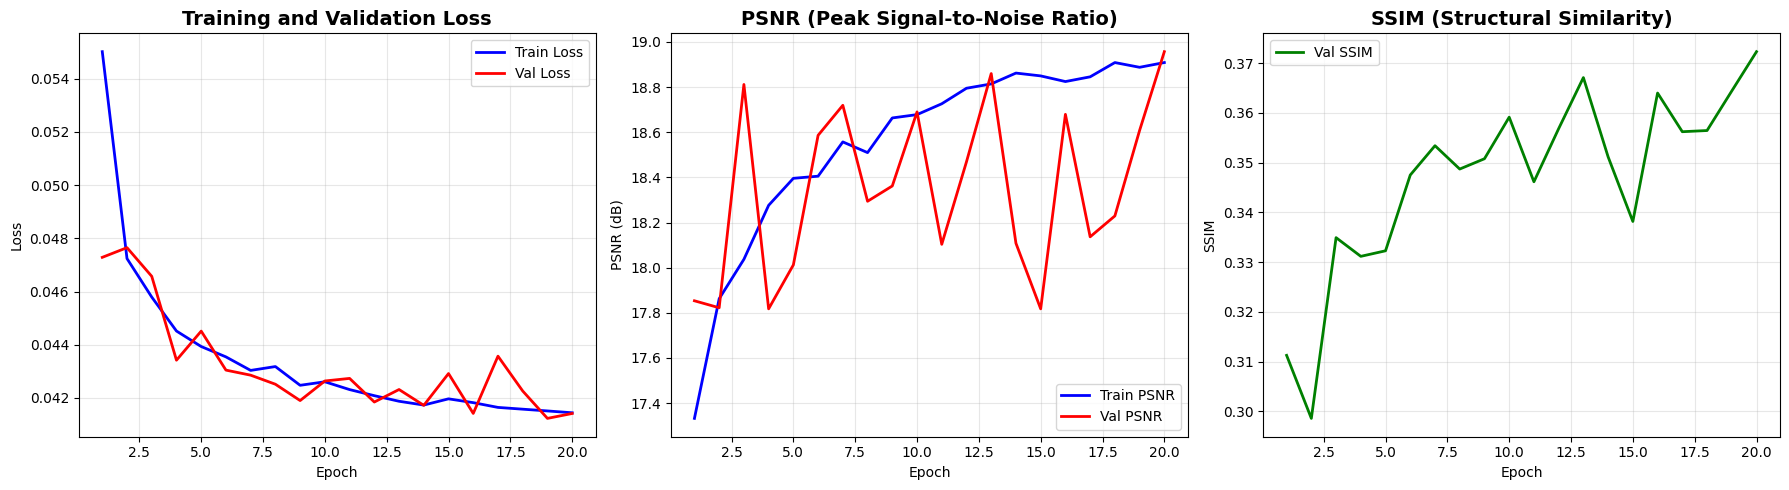

In [15]:
if len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # PSNR plot
    axes[1].plot(epochs, history['train_psnr'], 'b-', label='Train PSNR', linewidth=2)
    axes[1].plot(epochs, history['val_psnr'], 'r-', label='Val PSNR', linewidth=2)
    axes[1].set_title('PSNR (Peak Signal-to-Noise Ratio)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PSNR (dB)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # SSIM plot
    axes[2].plot(epochs, history['val_ssim'], 'g-', label='Val SSIM', linewidth=2)
    axes[2].set_title('SSIM (Structural Similarity)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No training history available")

## 13. Test Set Evaluation with Bicubic Baseline

In [18]:
# Load best model
if Path(SAVE_PATH).exists():
    checkpoint = torch.load(SAVE_PATH, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
    print(f"Best Val PSNR: {checkpoint['val_psnr']:.2f} dB")
    print(f"Best Val SSIM: {checkpoint['val_ssim']:.4f}")
    print("="*80)

# Evaluate on test set
if len(test_dataset) > 0:
    model.eval()
    
    test_psnr = 0
    test_ssim = 0
    bicubic_psnr_total = 0
    bicubic_ssim_total = 0
    num_batches = 0
    
    with torch.no_grad():
        for lr, hr, _ in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            
            # Model prediction
            sr = model(lr)
            
            # Calculate metrics for model
            batch_psnr = calculate_psnr(sr, hr)
            batch_ssim = calculate_ssim(sr, hr)
            
            # Calculate bicubic baseline
            bicubic_psnr, bicubic_ssim = calculate_bicubic_baseline(lr, hr, SCALE_FACTOR)
            
            test_psnr += batch_psnr
            test_ssim += batch_ssim
            bicubic_psnr_total += bicubic_psnr
            bicubic_ssim_total += bicubic_ssim
            num_batches += 1
    
    test_psnr /= num_batches
    test_ssim /= num_batches
    bicubic_psnr_total /= num_batches
    bicubic_ssim_total /= num_batches
    
    print("\nTest Set Evaluation:")
    print("="*80)
    print("\nBicubic Interpolation Baseline:")
    print(f"  PSNR: {bicubic_psnr_total:.2f} dB")
    print(f"  SSIM: {bicubic_ssim_total:.4f}")
    
    print("\nSRResNet Model:")
    print(f"  PSNR: {test_psnr:.2f} dB")
    print(f"  SSIM: {test_ssim:.4f}")
    
    print("\nImprovement over Bicubic:")
    print(f"  PSNR: +{test_psnr - bicubic_psnr_total:.2f} dB")
    print(f"  SSIM: +{test_ssim - bicubic_ssim_total:.4f}")
    print("="*80)
else:
    print("No test data available")

Loaded best model from epoch 20
Best Val PSNR: 18.96 dB
Best Val SSIM: 0.3723

Test Set Evaluation:

Bicubic Interpolation Baseline:
  PSNR: 13.87 dB
  SSIM: 0.1647

SRResNet Model:
  PSNR: 19.03 dB
  SSIM: 0.3823

Improvement over Bicubic:
  PSNR: +5.16 dB
  SSIM: +0.2177


## 14. Visual Comparison - Before and After Super-Resolution

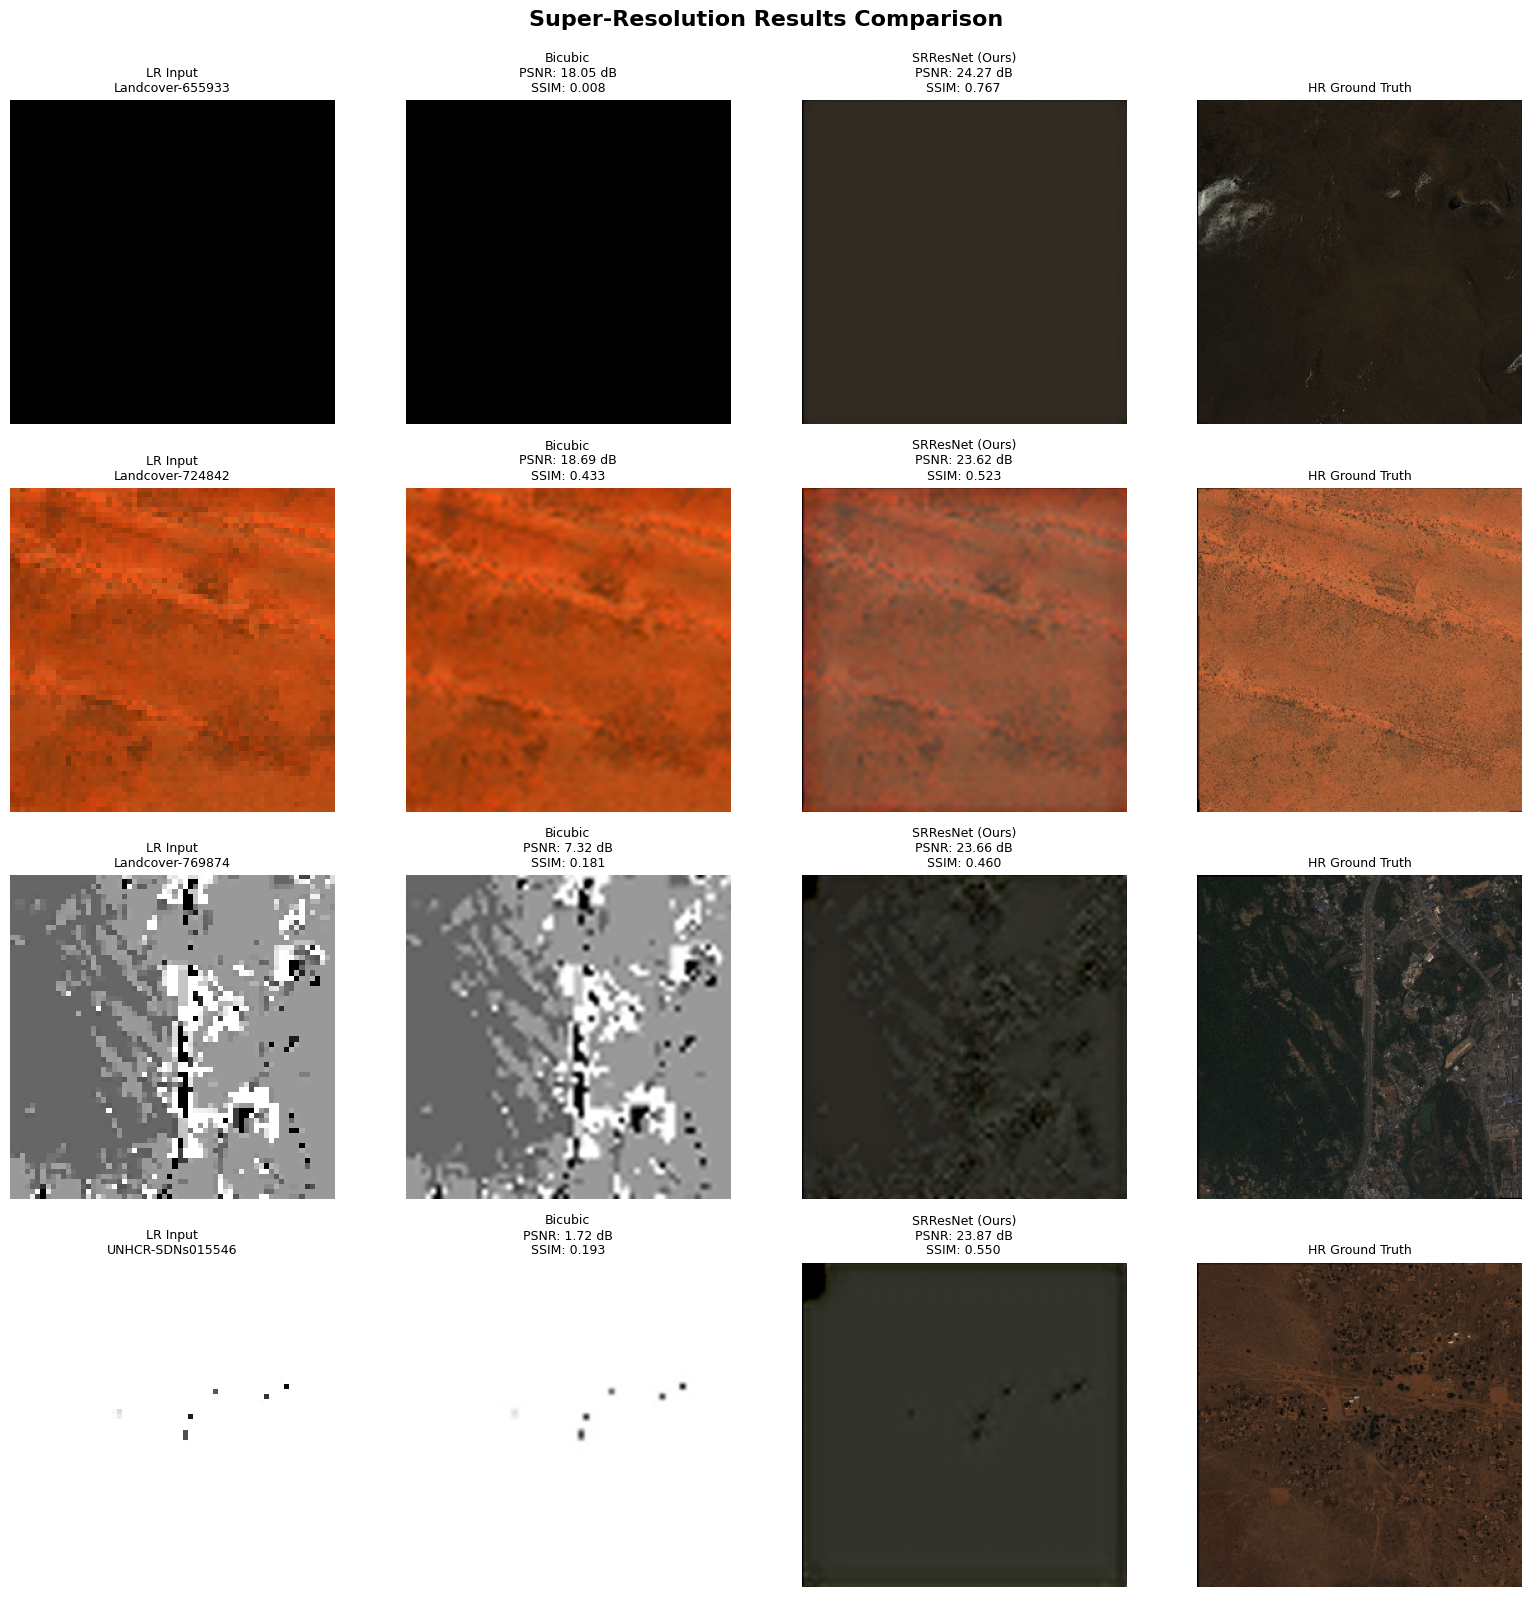

In [19]:
if len(test_dataset) > 0:
    model.eval()
    
    # Get test samples
    num_samples = min(4, len(test_dataset))
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i in range(num_samples):
            lr, hr, tile_name = test_dataset[i]
            lr_batch = lr.unsqueeze(0).to(device)
            
            # Generate SR image
            sr = model(lr_batch)
            
            # Generate bicubic baseline
            bicubic = nn.functional.interpolate(lr_batch, scale_factor=SCALE_FACTOR, mode='bicubic', align_corners=False)
            bicubic = torch.clamp(bicubic, 0, 1)
            
            # Convert to numpy for visualization
            lr_np = lr.permute(1, 2, 0).cpu().numpy()
            hr_np = hr.permute(1, 2, 0).cpu().numpy()
            sr_np = sr[0].permute(1, 2, 0).cpu().numpy()
            bicubic_np = bicubic[0].permute(1, 2, 0).cpu().numpy()
            
            # Calculate metrics
            sr_psnr = calculate_psnr(sr, hr.unsqueeze(0).to(device))
            sr_ssim = calculate_ssim(sr, hr.unsqueeze(0).to(device))
            bicubic_psnr = calculate_psnr(bicubic, hr.unsqueeze(0).to(device))
            bicubic_ssim = calculate_ssim(bicubic, hr.unsqueeze(0).to(device))
            
            # Plot images
            axes[i, 0].imshow(lr_np)
            axes[i, 0].set_title(f'LR Input\n{tile_name[:25]}', fontsize=9)
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(bicubic_np)
            axes[i, 1].set_title(f'Bicubic\nPSNR: {bicubic_psnr:.2f} dB\nSSIM: {bicubic_ssim:.3f}', fontsize=9)
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(sr_np)
            axes[i, 2].set_title(f'SRResNet (Ours)\nPSNR: {sr_psnr:.2f} dB\nSSIM: {sr_ssim:.3f}', fontsize=9)
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(hr_np)
            axes[i, 3].set_title(f'HR Ground Truth', fontsize=9)
            axes[i, 3].axis('off')
    
    plt.suptitle('Super-Resolution Results Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No test samples available for visualization")

## 15. Inference Function for New Images

In [ ]:
def super_resolve_image(model, image_path, device, scale_factor=4):
    """
    Perform super-resolution on a single image
    
    Args:
        model: Trained SR model
        image_path: Path to low-resolution image
        device: torch device
        scale_factor: Upscaling factor
    
    Returns:
        sr_image: Super-resolved image as numpy array
    """
    model.eval()
    
    # Load image
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Handle 16-bit to 8-bit conversion
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    
    # Convert to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] > 3:
        img = img[:, :, :3]
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        sr_tensor = model(img_tensor)
    
    # Convert back to numpy
    sr_image = sr_tensor[0].permute(1, 2, 0).cpu().numpy()
    sr_image = np.clip(sr_image, 0, 1)
    
    return sr_image


print("Inference function defined")

Inference function defined


## Example: Upscale a Test Image

Use the `super_resolve_image` function to upscale any low-resolution satellite image.

In [ ]:
# Example: Upscale a test image from the dataset
# Get a sample LR image path from test dataset
sample_tile = test_dataset.split_df.iloc[0]['tile']
lr_path, hr_path = test_dataset._get_image_paths(sample_tile)

print(f"Upscaling image for tile: {sample_tile}")
print(f"LR Image path: {lr_path}")
print(f"HR Image path: {hr_path}")

# Perform super-resolution
sr_image = super_resolve_image(model, lr_path, device, scale_factor=SCALE_FACTOR)

# Load original images for comparison
lr_img = tifffile.imread(str(lr_path))
# Extract RGB bands
if len(lr_img.shape) == 3 and lr_img.shape[2] >= 4:
    lr_img = np.stack([lr_img[:, :, 3], lr_img[:, :, 2], lr_img[:, :, 1]], axis=2)
# Normalize
if lr_img.dtype == np.uint16:
    lr_img = (lr_img / 256).astype(np.uint8)
lr_img = lr_img.astype(np.float32) / 255.0

hr_img = cv2.imread(str(hr_path))
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

# Resize LR for display
lr_display = cv2.resize(lr_img, (256, 256), interpolation=cv2.INTER_CUBIC)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(lr_display)
axes[0].set_title('Low Resolution Input', fontsize=12)
axes[0].axis('off')

axes[1].imshow(sr_image)
axes[1].set_title('Super-Resolved (Model)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(hr_img)
axes[2].set_title('High Resolution Ground Truth', fontsize=12)
axes[2].axis('off')

plt.suptitle(f'Super-Resolution Result for {sample_tile}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTo upscale your own image:")
print("sr_result = super_resolve_image(model, 'path/to/your/lr_image.tiff', device)")
print("\nTo save the result:")
print("plt.imsave('output_sr.png', sr_result)")

## 16. Summary and Conclusion

## Summary

This notebook implements a complete super-resolution pipeline for satellite imagery:

### Key Components:
1. **Dataset**: WorldStrat satellite imagery with LR (Sentinel-2) and HR (Commercial) pairs
2. **Model**: SRResNet with residual blocks and pixel shuffle upsampling
3. **Loss Function**: Perceptual loss combining MSE and edge preservation
4. **Metrics**: PSNR and SSIM for quantitative evaluation

### Features:
- 4x upscaling of low-resolution satellite images
- Prevents hallucination through edge-preserving loss
- Bicubic interpolation baseline comparison
- Comprehensive evaluation on train/val/test splits

### Technical Specifications:
- Scale Factor: 4x
- Input Resolution: 64x64 (10m/pixel)
- Output Resolution: 256x256 (2.5m/pixel)
- Model Parameters: Deep residual network with 8 residual blocks
- Optimizer: Adam with learning rate scheduling

### Evaluation Criteria:
- Mathematical Accuracy: PSNR and SSIM metrics
- Visual Quality: Edge sharpness and color consistency
- Hallucination Prevention: Edge-preserving loss function